In [1]:
# 필요한 라이브러리 로드
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

In [2]:
# 한글 폰트 설정
candidates = [
    "AppleGothic",        # macOS
    "Malgun Gothic",      # Windows
    "NanumGothic", "Nanum Gothic", "Noto Sans CJK KR", "Noto Sans KR"  # Linux 등
]
for name in candidates:
    try:
        # 폰트가 실제로 존재하는지 확인
        font_path = font_manager.findfont(name, fallback_to_default=False)
        if os.path.exists(font_path):
            rcParams["font.family"] = name
            break
    except Exception:
        continue
# 마이너스 기호 깨짐 방지
rcParams["axes.unicode_minus"] = False

# 상관분석
def corr_and_heatmap(df: pd.DataFrame, feature_cols, out_dir, pilename):
    """피어슨 상관행렬 CSV와 히트맵 PNG 저장(EDA 목적)"""
    os.makedirs(out_dir, exist_ok=True)
    corr = df[feature_cols].corr(method="pearson")
    csv_path = os.path.join(out_dir, f"{pilename}_corr.csv")
    png_path = os.path.join(out_dir, f"{pilename}_corr.png")
    corr.to_csv(csv_path, encoding="utf-8-sig")

    plt.figure(figsize=(8, 6))
    plt.imshow(corr, interpolation="nearest", aspect="auto")
    plt.title(f"Pearson Correlation ({pilename})")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=7)
    plt.yticks(range(len(corr.index)),   corr.index,   fontsize=7)
    plt.tight_layout()
    plt.savefig(png_path, dpi=200)
    plt.show()

In [3]:
# 데이터 로드
market = pd.read_csv('data/상장.csv')
unlist = pd.read_csv('data/비상장.csv')
all = pd.read_csv('data/all.csv')

In [5]:
# feature가 아닌 컬럼
drop_cols = ['회사명', '거래소코드', '회계년도', '산업코드', '산업명', 'label']

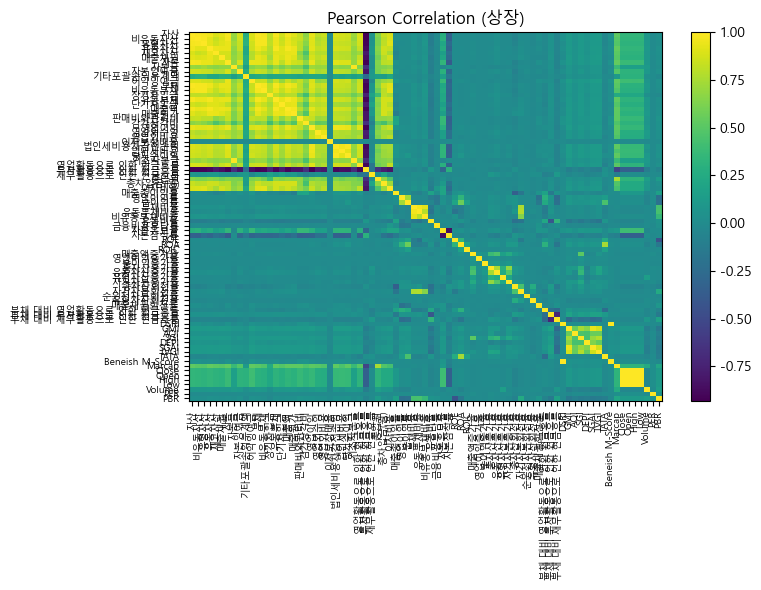

In [21]:
corr_and_heatmap(market, market.drop(drop_cols, axis=1).columns, 'heatmap', '상장')

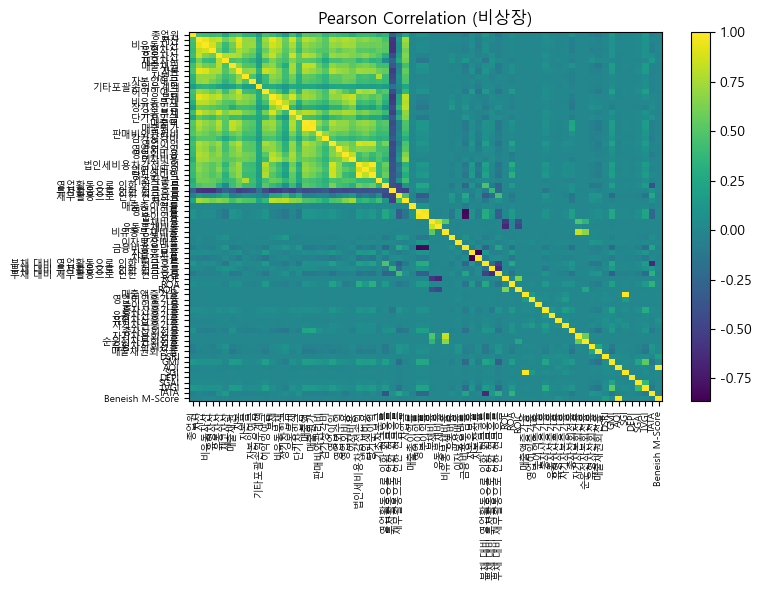

In [ ]:
corr_and_heatmap(unlist,unlist.drop(drop_cols, axis=1).columns, 'heatmap', '비상장')

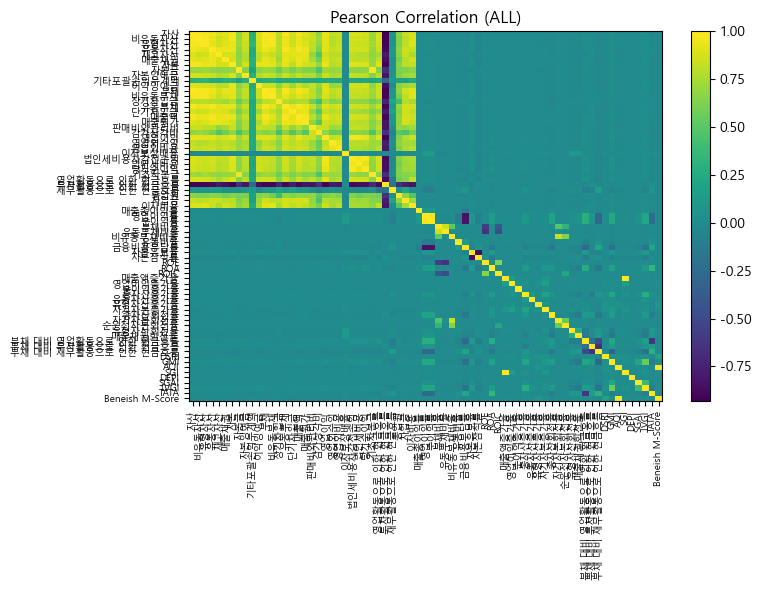

In [6]:
corr_and_heatmap(all,all.drop(drop_cols, axis=1).columns, 'heatmap', 'ALL')

In [8]:
sample_col = ['자산', '자본', '부채', '매출액', '영업이익', '당기순이익', '영업활동으로 인한 현금흐름', '재무활동으로 인한 현금흐름', '투자활동으로 인한 현금흐름', '매출총이익률', '순이익률', '매출액증가율', '영업이익증가율', 'Beneish M-Score']

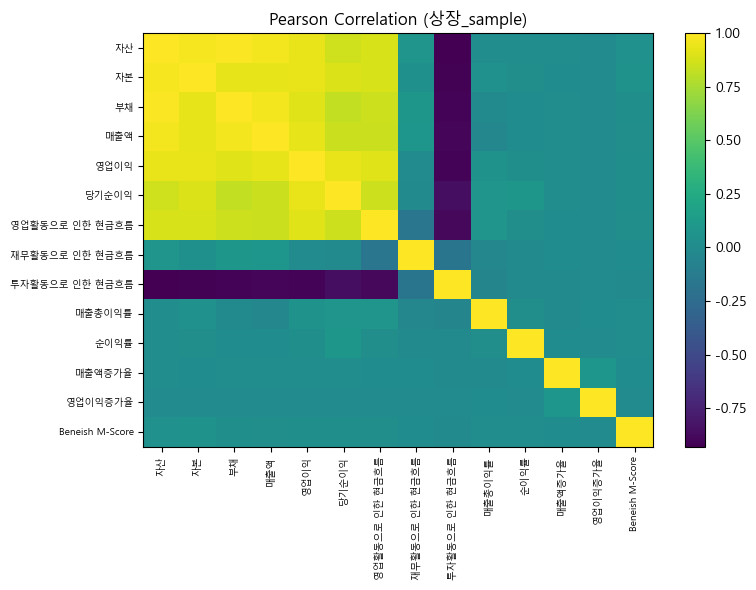

In [9]:
corr_and_heatmap(market, sample_col, 'heatmap', '상장_sample')

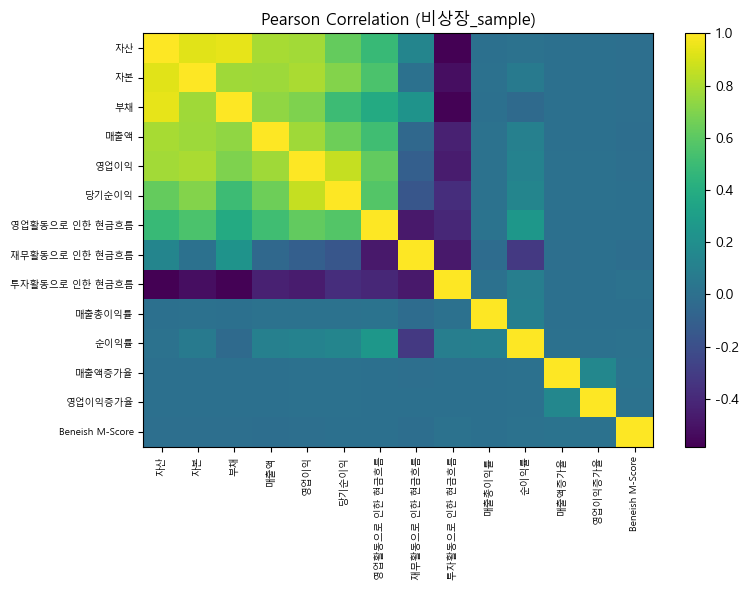

In [10]:
corr_and_heatmap(unlist, sample_col, 'heatmap', '비상장_sample')

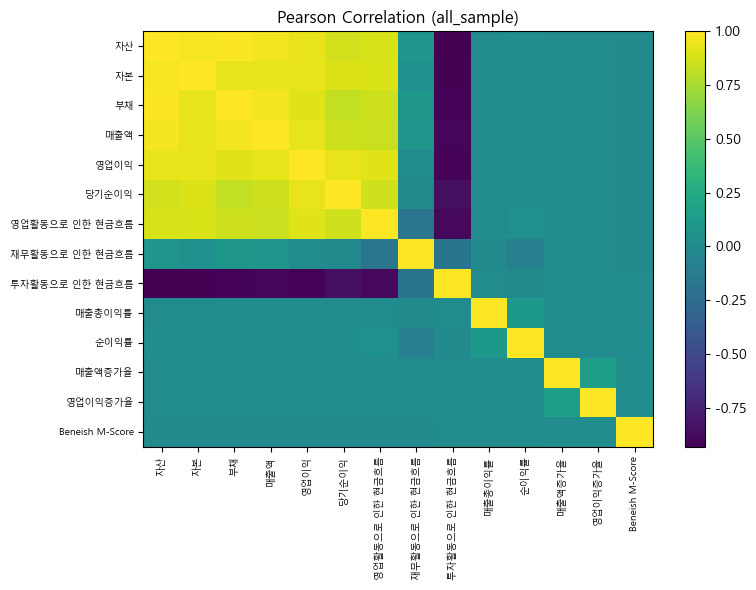

In [11]:
corr_and_heatmap(all, sample_col, 'heatmap', 'all_sample')

In [ ]:
#PCA
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, thresh=10.0):
    """
    VIF 계산 후, threshold 이상인 컬럼 제거
    """
    
    # VIF 계산
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [
        variance_inflation_factor(df.values, i)
        for i in range(df.shape[1])
    ]
    
    # VIF 10 이상 컬럼 필터링
    high_vif = vif_data[vif_data["VIF"] > thresh]["feature"].tolist()
    
    # 결과
    vif_table = vif_data.sort_values("VIF", ascending=False)
    
    # 걸러낸 데이터프레임
    filtered_df = df.drop(columns=high_vif)
    
    print("VIF 결과표:")
    print(vif_table)
    print("\n제거된 컬럼들:")
    print(set(df.columns) - set(filtered_df.columns))
    
    return filtered_df

from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler

def EN_feature_select(X, y, scale = 'minmax') :
        
    if scale == 'minmax' :
        scaler = MinMaxScaler()
    elif scale == 'standard' :
        scaler = StandardScaler()
    else :
        raise ValueError ("scale = minmax or standard")
    
    feature_names = X.columns

    X_scaled = scaler.fit_transform(X)


    # 엘라스틱넷CV (교차검증으로 최적 alpha와 l1_ratio 선택)
    elastic_net = ElasticNetCV(
        l1_ratio=[.1, .5, .7, .9, .95, .99, 1],  # L1/L2 비율 후보
        alphas=np.logspace(-4, 1, 50),           # 규제 강도 후보
        cv=5,
        max_iter=10000,
        random_state=42
    )

    elastic_net.fit(X_scaled, y)

    # 회귀계수
    coef = elastic_net.coef_

    # 피처와 계수 정리
    selected_features = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coef,
        "Abs_Coefficient": np.abs(coef)
    })

    # 계수 절댓값이 큰 순서로 정렬
    selected_features.sort_values("Abs_Coefficient", ascending = False, inplace=True)
    selected_features.reset_index(drop=True, inplace=True)

    print("ElasticNet 최적 alpha:", elastic_net.alpha_)
    print("ElasticNet 최적 l1_ratio:", elastic_net.l1_ratio_)
    print(f"\n {selected_features[:15]}")
    
    return(selected_features.loc[:15,"Feature"])

def PCA_feature_select(df, scale = 'minmax', n_components = 5) :
    # 1. Sparse PCA 수행
    X = df.copy()
    cols = X.columns
    if scale == 'minmax' :
        scaler = MinMaxScaler()
    elif scale == 'standard' :
        scaler = StandardScaler()
    else :
        raise ValueError ("scale = minmax or standard")
    
    X = scaler.fit_transform(X)
    spca = SparsePCA(n_components=n_components, alpha=1, random_state=42)
    spca.fit(X)

    # 2. 로딩 확인 (피처 x PC)
    sparse_loadings = pd.DataFrame(
        spca.components_.T,
        index = cols,
        columns=[f'PC{i+1}' for i in range(n_components)]
    )

    for pc in sparse_loadings.columns:
        print(f"\n{pc} 상위 기여 피처:")
        print(sparse_loadings[pc].abs().sort_values(ascending=False).head(5))

    pc_variances = pd.Series([X.dot(spca.components_[i,:]).var() for i in range(n_components)],
                            index=[f'PC{i+1}' for i in range(n_components)])
    # 전체 분산 대비 비율
    pc_variance_ratio = pc_variances / pc_variances.sum()
    
    ratio_sum = 0
    n = 1
    while ratio_sum < 0.85 :
        ratio_sum += pc_variance_ratio[f'PC{n}']
        n += 1

    select_pc = pc_variance_ratio[:f'PC{n}']
    select_features = []
    for pc in select_pc.index :
        for feature in sparse_loadings[pc].abs().sort_values(ascending=False).head(5).index :
            if (feature not in select_features) and (sparse_loadings[pc].abs()[feature] > 0.0000009) :
                select_features.append(feature)
    return select_features

In [16]:
df = pd.read_csv('data/상장.csv')
drop_cols = ['회사명', '거래소코드', '회계년도', '산업코드', '산업명', 'label']
X = df.loc[df['회계년도'] <= '2017/12', df.drop(columns=drop_cols).columns]
y = df.loc[df['회계년도'] <= '2017/12', 'label']
filtered_X = calculate_vif(X, thresh=10)
select_features = EN_feature_select(filtered_X, y, scale = 'minmax')

VIF 결과표:
     feature            VIF
73      Open  649843.733141
72     Close  588263.626225
74      High  338796.897414
75       Low  336357.679654
37      부채비율   41961.077735
..       ...            ...
49    순이익증가율       1.026996
77       PER       1.019711
48   영업이익증가율       1.010228
56  순운전자본회전율       1.009714
23    이자보상배율       1.002475

[79 rows x 2 columns]

제거된 컬럼들:
{'판매비와관리비', '비유동부채비율', '자본잉여금', '재고자산', 'Beneish M-Score', '기초자본금', 'GMI', '유동자산', '총차입금(원)', '비유동자산', '영업이익', 'SGAI', '법인세비용', '투자활동으로 인한 현금흐름', '당기순이익', 'DSRI', '유동부채비율', 'High', '매출채권', '유동부채', '이자비용', '이익잉여금', '자산', '영업외비용', '자본금', 'Open', '자본', '단기차입금', 'Close', '영업외수익', '법인세비용차감전손익', '유형자산', 'Low', '매출액', '부채', '부채비율', '영업활동으로 인한 현금흐름', '비유동부채', '매출원가'}
ElasticNet 최적 alpha: 0.0002559547922699536
ElasticNet 최적 l1_ratio: 0.1

                  Feature  Coefficient  Abs_Coefficient
0                    ROA    -1.184582         1.184582
1                  영업이익률    -1.180523         1.180523
2   부채 대비 영업활동으로 인한 현금

In [17]:
df = pd.read_csv('data/비상장.csv')
drop_cols = ['회사명', '거래소코드', '회계년도', '산업코드', '산업명', 'label']
X = df.loc[df['회계년도'] <= '2017/12', df.drop(columns=drop_cols).columns]
y = df.loc[df['회계년도'] <= '2017/12', 'label']
filtered_X = calculate_vif(X, thresh=10)
select_features = EN_feature_select(filtered_X, y, scale = 'minmax')

VIF 결과표:
            feature           VIF
70  Beneish M-Score  1.204171e+13
64              AQI  1.154769e+13
62             DSRI  2.685990e+11
36             부채비율  5.862806e+09
37           유동부채비율  5.849340e+09
..              ...           ...
39             유동비율  1.063934e+00
40           이자보상배율  1.063248e+00
54          유동자산증가율  1.045729e+00
55          유형자산증가율  1.029909e+00
33           매출총이익률  1.013811e+00

[71 rows x 2 columns]

제거된 컬럼들:
{'비유동부채비율', '매출액증가율', 'Beneish M-Score', 'ROE', '유동자산', '비유동자산', '영업이익', '법인세비용', '차입금', '당기순이익', 'DSRI', '유동부채비율', '장기차입금', '유동부채', '자산', '순이익률', '자본', '단기차입금', 'AQI', '법인세비용차감전손익', 'SGI', '매출액', '부채', '부채비율', '영업이익률', '비유동부채', '매출원가'}
ElasticNet 최적 alpha: 0.0001
ElasticNet 최적 l1_ratio: 0.99

                  Feature  Coefficient  Abs_Coefficient
0                    GMI    -7.367864         7.367864
1                    ROA    -6.698332         6.698332
2                   LVGI    -3.891805         3.891805
3                 총자산회전율    -2.833

In [ ]:
df = pd.read_csv('data/ALL.csv')
drop_cols = ['회사명', '거래소코드', '회계년도', '산업코드', '산업명', 'label']
X = df.loc[df['회계년도'] <= '2017/12', df.drop(columns=drop_cols).columns]
y = df.loc[df['회계년도'] <= '2017/12', 'label']
filtered_X = calculate_vif(X, thresh=10)
select_features = EN_feature_select(filtered_X, y, scale = 'minmax')

VIF 결과표:
            feature           VIF
70  Beneish M-Score  9.561783e+12
64              AQI  9.172301e+12
62             DSRI  2.134155e+11
37             부채비율  5.707576e+09
38           유동부채비율  5.694466e+09
..              ...           ...
23           이자보상배율  1.059144e+00
51          유동자산증가율  1.044895e+00
52          유형자산증가율  1.028759e+00
40             유동비율  1.020310e+00
34           매출총이익률  1.013320e+00

[71 rows x 2 columns]

제거된 컬럼들:
{'판매비와관리비', '비유동부채비율', '재고자산', '매출액증가율', 'Beneish M-Score', 'ROE', '기초자본금', '유동자산', '비유동자산', '영업이익', '법인세비용', '투자활동으로 인한 현금흐름', '차입금', '당기순이익', 'DSRI', '유동부채비율', '매출채권', '유동부채', '이익잉여금', '이자비용', '자산', '영업외비용', '자본금', '순이익률', '자본', '단기차입금', 'AQI', '영업외수익', '법인세비용차감전손익', '유형자산', 'SGI', '매출액', '부채', '영업활동으로 인한 현금흐름', '부채비율', '영업이익률', '비유동부채', '매출원가'}
ElasticNet 최적 alpha: 0.0001
ElasticNet 최적 l1_ratio: 1.0

                  Feature  Coefficient  Abs_Coefficient
0                    GMI    -7.563478         7.563478
1                    ROA    -7.1

0                      GMI
1                      ROA
2                     LVGI
3                   총자산회전율
4     부채 대비 영업활동으로 인한 현금흐름
5     부채 대비 재무활동으로 인한 현금흐름
6                   이자보상배율
7                  금융비용부담률
8                  매출채권회전율
9                    자본잉여금
10                 유형자산회전율
11                   감가상각비
12                 유형자산증가율
13               기타포괄손익누계액
14    부채 대비 투자활동으로 인한 현금흐름
15                    DEPI
Name: Feature, dtype: object

In [ ]:
df = pd.read_csv('data/상장.csv')
drop_cols = ['회사명', '거래소코드', '회계년도', '산업코드', '산업명', 'label']
df = df.loc[df['회계년도'] <= '2017/12', df.drop(columns=drop_cols).columns]
filtered_df = calculate_vif(df, thresh=10)
PCA_feature_select(df)

VIF 결과표:
     feature            VIF
73      Open  649843.733141
72     Close  588263.626225
74      High  338796.897414
75       Low  336357.679654
37      부채비율   41961.077735
..       ...            ...
49    순이익증가율       1.026996
77       PER       1.019711
48   영업이익증가율       1.010228
56  순운전자본회전율       1.009714
23    이자보상배율       1.002475

[79 rows x 2 columns]

제거된 컬럼들:
{'영업이익', '법인세비용차감전손익', 'GMI', '자산', 'Close', '자본금', '이자비용', '영업활동으로 인한 현금흐름', 'Beneish M-Score', '매출채권', 'Open', '영업외수익', '유동부채', '부채비율', '부채', '이익잉여금', '비유동부채비율', '영업외비용', '기초자본금', '자본잉여금', '유동부채비율', '유동자산', '단기차입금', 'SGAI', 'High', '당기순이익', '유형자산', '매출액', '재고자산', '투자활동으로 인한 현금흐름', '비유동자산', '매출원가', '판매비와관리비', 'DSRI', '법인세비용', '총차입금(원)', 'Low', '비유동부채', '자본'}

PC1 상위 기여 피처:
매출채권     0.289818
단기차입금    0.278460
부채       0.270350
매출원가     0.270069
재고자산     0.266350
Name: PC1, dtype: float64

PC2 상위 기여 피처:
LVGI    0.578680
SGAI    0.566295
GMI     0.548659
SGI     0.203590
AQI     0.039252
Name: PC2, dtype: float64

PC

In [ ]:
df = pd.read_csv('data/비상장.csv')
drop_cols = ['회사명', '거래소코드', '회계년도', '산업코드', '산업명', 'label']
df = df.loc[df['회계년도'] <= '2017/12', df.drop(columns=drop_cols).columns]
filtered_df = calculate_vif(df, thresh=10)
PCA_feature_select(df)

VIF 결과표:
            feature           VIF
70  Beneish M-Score  1.204171e+13
64              AQI  1.154769e+13
62             DSRI  2.685990e+11
36             부채비율  5.862806e+09
37           유동부채비율  5.849340e+09
..              ...           ...
39             유동비율  1.063934e+00
40           이자보상배율  1.063248e+00
54          유동자산증가율  1.045729e+00
55          유형자산증가율  1.029909e+00
33           매출총이익률  1.013811e+00

[71 rows x 2 columns]

제거된 컬럼들:
{'영업이익', '법인세비용차감전손익', '자산', '매출액증가율', '영업이익률', 'AQI', 'Beneish M-Score', '유동부채', '부채', '비유동부채비율', 'SGI', '유동부채비율', '유동자산', '단기차입금', '당기순이익', '자본', '비유동자산', '차입금', 'ROE', '장기차입금', '순이익률', '매출원가', 'DSRI', '비유동부채', '법인세비용', '매출액', '부채비율'}

PC1 상위 기여 피처:
영업이익률             0.628377
순이익률              0.603561
금융비용부담률           0.489533
재무활동으로 인한 현금흐름    0.025991
이자보상배율            0.016658
Name: PC1, dtype: float64

PC2 상위 기여 피처:
차입금      0.294157
부채       0.287787
비유동부채    0.263099
이자비용     0.259291
자산       0.248503
Name: PC2, dtype: float64

PC3 상

In [ ]:
df = pd.read_csv('data/ALL.csv')
drop_cols = ['회사명', '거래소코드', '회계년도', '산업코드', '산업명', 'label']
df = df.loc[df['회계년도'] <= '2017/12', df.drop(columns=drop_cols).columns]
filtered_df = calculate_vif(df, thresh=10)
PCA_feature_select(df)

VIF 결과표:
            feature           VIF
70  Beneish M-Score  9.561783e+12
64              AQI  9.172301e+12
62             DSRI  2.134155e+11
37             부채비율  5.707576e+09
38           유동부채비율  5.694466e+09
..              ...           ...
23           이자보상배율  1.059144e+00
51          유동자산증가율  1.044895e+00
52          유형자산증가율  1.028759e+00
40             유동비율  1.020310e+00
34           매출총이익률  1.013320e+00

[71 rows x 2 columns]

제거된 컬럼들:
{'영업이익', '법인세비용차감전손익', '자산', '자본금', '이자비용', '영업이익률', '매출액증가율', 'AQI', '매출채권', 'Beneish M-Score', '영업외수익', '유동부채', '부채', '이익잉여금', '비유동부채비율', '영업외비용', '기초자본금', 'SGI', '유동부채비율', '유동자산', '단기차입금', '당기순이익', '유형자산', '자본', '재고자산', '투자활동으로 인한 현금흐름', '비유동자산', '차입금', 'ROE', '순이익률', '매출원가', '판매비와관리비', 'DSRI', '비유동부채', '영업활동으로 인한 현금흐름', '법인세비용', '매출액', '부채비율'}

PC1 상위 기여 피처:
영업이익률                   0.710425
순이익률                    0.703696
이자보상배율                  0.009268
총자산회전율                  0.003604
부채 대비 영업활동으로 인한 현금흐름    0.002351
Name: PC1, dtype: fl